# Pratique de geopandas: données vélib

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_TP.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/manipulation/03_geopandas_TP.ipynb%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=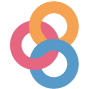" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_TP.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/03_geopandas_TP.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Installations préalables :

In [2]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas

In [3]:
import geopandas as gpd

# Lire et enrichir des données spatiales

Dans cette partie, nous utiliserons la fonction suivante, qui facilite
le téléchargement et le dézippage des données proposées sur `data.gouv`:

In [4]:
import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
  with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

<div class="alert alert-success" role="alert">

1.  Utiliser la fonction `download_unzip` avec l’url <https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12>
    pour télécharger les données communales.
2.  Importer le fichier avec la package `geopandas`
    (si vous avez laissé les paramètres par défaut,
    le fichier devrait
    être à l’emplacement `temporary_location + "/borders/communes-20190101.json"`).
    Vous pouvez le nommer `communes_borders`
3.  Regarder les premières lignes des données. Identifier la différence avec
    un DataFrame standard.
4.  Afficher l’attribut `crs` de `communes_borders`. Ce dernier contrôle la
    transformation de l’espace tridimensionnel terrestre en une surface plane.
5.  Afficher les communes de l’Aveyron (département 12) et utiliser la méthode
    `plot`
6.  Réprésenter la carte de Paris : quel est le problème ?

</div>

En effet, on ne dispose ainsi pas des limites des arrondissements parisiens, ce
qui appauvrit grandement la carte de Paris. On peut les récupérer directement
depuis le site d’open data du grand Paris
(cf. [tutoriel du chapitre précédent](geopandas)).

<div class="alert alert-success" role="alert">

1.  Importer les données de découpage des arrondissements parisiens à l’adresse
    <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>
2.  Vérifier sur une carte que les découpages des arrondissements sont bien présents
3.  Vérifier l’attribut `crs`. Est-il cohérent avec celui des données communales ?
4.  Retirer Paris du jeu de données communales et utiliser les arrondissements
    pour enrichir (nommer l’objet obtenu `data_borders`). Ici, on peut ne pas se
    soucier de la variable commune de superficie aux niveaux différents car on
    va la recréer. En revanche, renommer la variable `c_arinsee` en `insee` avec
    la méthode `rename` et faire attention aux types des variables
5.  Créer une variable `dep` stockant le département
6.  Représenter les communes de la petite couronne parisienne (75, 92, 93, 94)

</div>

# Utiliser des données géographiques comme des couches graphiques

Souvent, le découpage communal ne sert qu’en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données. On va partir des données de localisation des
stations velib,
disponibles [sur le site d’open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et
requêtables directement par l’url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

<div class="alert alert-success" role="alert">

1.  Importer les données velib sous le nom `station`
2.  Représenter sur une carte les 50 stations les plus importantes (variable `capacity`). Vous pouvez également afficher le fonds de carte des arrondissements en ne gardant que les départements de la petite couronne (75, 92, 93, 94).
    Cette [page](https://geopandas.org/mapping.html#maps-with-layers) peut vous aider pour afficher plusieurs couches à la fois.
3.  Afficher également les réseaux de transport en communs, disponibles [ici](https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/map/?location=7,48.69717,2.33167&basemap=jawg.streets). L’url à requêter est
    <https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

</div>

# Jointures spatiales

Les jointures attributaires fonctionnent comme avec un DataFrame `pandas`. Pour conserver un objet spatial *in fine*, il faut faire attention à utiliser en premier (base de gauche) l’objet `geopandas`. En revanche, l’un des intérêts des objets geopandas est qu’on peut également faire une jointure sur la dimension spatiale.

La documentation à laquelle se référer est [ici](https://geopandas.org/mergingdata.html#spatial-joins).

<div class="alert alert-success" role="alert">

1.  Faire une jointure spatiale pour enrichir les données de stations en y ajoutant des informations de `data_paris`. Appeler cet objet `stations_info`
2.  Représenter la carte des stations du 19e arrondissement (s’aider de la variable `c_ar`). Vous pouvez mettre en fond de carte les arrondissements parisiens.
3.  Compter le nombre de stations velib et le nombre de places velib par arrondissement ou commune (pour vous aider, vous pouvez compléter vos connaissances avec [ce tutoriel](https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html)). Représenter sur une carte chacune des informations
4.  Représenter les mêmes informations mais en densité (diviser par la surface de l’arrondissement ou commune en km2)

</div>

# Trouver la station la plus proche

Une aide [ici](https://pysal.org/scipy2019-intermediate-gds/deterministic/gds1-relations.html#how-about-nearest-neighbor-joins)

Cet exemple peut également vous aider à comprendre certains concepts :

<div class="alert alert-success" role="alert">

1.  Charger la localisation des stations de transports présente ici : https://data.ratp.fr/explore/dataset/accessibilite-des-gares-et-stations-metro-et-rer-ratp/download/?format=geojson&timezone=Europe/Berlin&lang=fr. Appelez-la `stations_transport` et ne gardez que les variables ‘nomptar’ et ‘geometry’.
2.  Trouver la station de transport la plus proche de la station de vélib “Edgard Quinet - Gaité”. La ligne de code `ensemble_stations = stations_transport.unary_union` vous sera utile ainsi que l’importation de la fonction `from shapely.ops import nearest_points`.
3.  Généraliser aux 10 premières lignes de la table `stations` des vélibs en indiquant pour chaque station velib quelle est la station de transport en commun la plus proche dans une nouvelle colonne appelée `Nearest`.

</div>